TIME SERIES ANALYSIS AND FORECASTING USING ARIMA 

Time series is a sequence of observations recorded at regular time intervals. Time series can be hourly, daily, weekly, monthly, quarterly and annual. Sometimes, even seconds, minute-wise.
Analysing timeseries is important as is the preparatory step before forecasting the series.
Time series forecasting has enormous commercial significance because stuff that is important to a business like energy generation, number of visitors to a website, stock price etc are essentially time series data.

TIME SERIES ANALYSIS

Time series analysis involves understanding various aspects about the inherent nature of the series so that you are better informed to create meaningful and accurate forecasts.


In [9]:
# importing libraries
from pandas import read_csv
import pandas as pd
from pandas import datetime
from matplotlib import pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error as mse
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from numpy import log
import numpy as np
import math 

import pmdarima as pm
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.linear_model import LinearRegression
import itertools

Reading Time series data

The time series data is typically stores in .csv files or other spreadsheet formats and contains the date, time and measured values.
The data for this tutorial is downloaded from MESO in a .csv format. It has Year, Month, Data and hourly readings from 2014-2019.
The time data is clubbed and used as index for the measured values.

In [10]:
# Read data
x=pd.read_csv('Wind Forecast Data.csv')
x['Datetime']=pd.to_datetime(x[['Year', 'Month', 'Day', 'Hour']])
series=x[['Datetime','Wind Actual']]
series = series.set_index('Datetime')
series = pd.Series(series['Wind Actual'], index=series.index)
# dseries=series.resample('D').mean()
X=series.values

Decomposing data to analyse Patterns in the time series

Any time series may be split into the following components: Trend, Seasonality and Error

A trend is observed as an increasing or decreasing slope observed in the plot. Whereas seasonality is observed when there is a distinct repeated pattern observed at regular time intervals due to seasonal factors. 
However, It is not mandatory that all time series must have a trend and/or seasonality. A time series may not have a distinct seasonality but have a trend as in our case. The opposite can also be true.

Depending on the nature of the series, it can be modeled as an additive or multiplicative, wherein, each observation can be expressed as either a sum or a product of the components.

Additive time series:
Value = Base Level + Trend + Seasonality + Error

Multiplicative Time Series:
Value = Base Level x Trend x Seasonality x Error

The Plot below shows the additive time series.

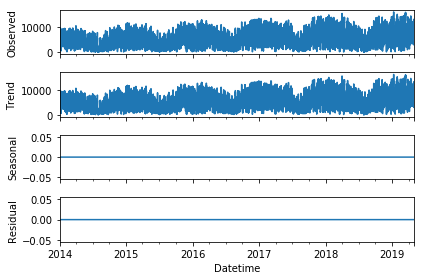

In [11]:
from random import randrange
from statsmodels.tsa.seasonal import seasonal_decompose
result1 = seasonal_decompose(series, model='additive',freq=1)
result1.plot()
plt.show()
plt.close()

What is stationary series?

A stationary series is a time series where the values is not a function of time. It is also devoid of seasonal effects as the statistical properties like mean and variance are constant over time. 

What are the methods to make a series stationary?

The methods to make data series stationary are as follows:

a. Differencing the Series

b. Take the log of the series

c. Take the nth root of the series

In in this tutorial we difference the series to make it stationary. We are subtracting the next value by the current value.
If the first difference doesnot make a series stationary, we can difference the series further, till it becomes stationary.

Why stationarityy?

Making series stationary is important as forecasts of stationary series are more reliable and the process is easy. 
Also, regression forecasting models are essentially linear models that utilize the lags of the variables as predictors and by making series stationary we are removing corelation between lags. 

How to test for it?

The stationarity of a series can be established by looking at the plot of the series. But the most reliable way is to perform a statistical test called unit root test. There are multiple implementations of Unit Root tests like:

a.Augmented Dickey Fuller test (ADH Test) 

b.Kwiatkowski-Phillips-Schmidt-Shin – KPSS test (trend stationary) 

c.Philips Perron test (PP Test) 

In this tutorial we perform ADH and KPSS tests using statsmodels package. In the ADF test, null hypothesis is there exist a unit root and is non-stationary. 
KPSS test is used to test for trend stationarity. The null hypothesis and the P-Value interpretation is the opposite of ADH test. 

In [12]:
series1=series
# print(series1)
# ADH test
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1]) 
# so d=1,p=0,q=2 from 100 data

# KPSS Test
result = kpss(series1.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -19.041557
p-value: 0.000000

KPSS Statistic: 6.189381
p-value: 0.010000


C:\Users\Bhavya\Anaconda1\lib\site-packages\statsmodels\tsa\stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
C:\Users\Bhavya\Anaconda1\lib\site-packages\statsmodels\tsa\stattools.py:1708: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


Our the p-value of the ADF test is less than the significance level (0.05), so we can reject the null hypothesis and infer that the time series is indeed stationary. But the KPSS p-value doesnt agree with it. We will further look at the decomposed time series plot, ACF and PACF plots to decide if we need differencing before developing model. The following plots show how would the series look if they are differenced further.

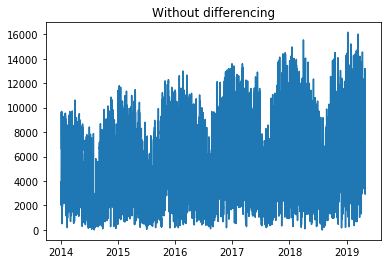

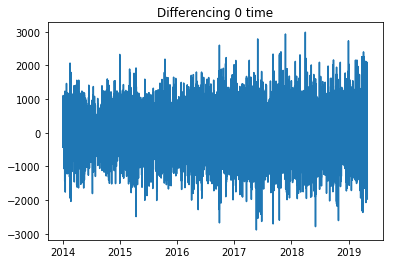

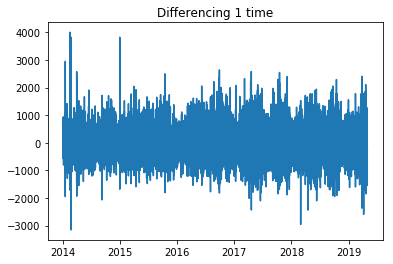

In [13]:
series1=series
plt.plot(series1)
plt.title('Without differencing')
plt.show()
plt.close()
for i in range(2):
    series1=series1.diff().dropna()
    plt.plot(series1)
    plt.title('Differencing %i time' % i)
    plt.show()
    plt.close()
    

Series can be detrended from time series to remove the trend component from a time series by subtracting the line of best fit from the time series, using filters like Baxter-King filter or the Hodrick-Prescott Filter, subtracting the trend component obtained decomposing time series and subtracting the mean. Baxter-King filter or the Hodrick-Prescott Filter from scipy and statsmod libraries remove the moving average trend lines and /or the cyclical components. This tutorial shows detrending by subtracting the line of best fit from the time series.


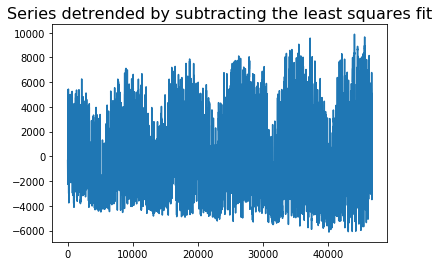

In [14]:
# Using scipy: Subtract the line of best fit
from scipy import signal
detrended = signal.detrend(X)
plt.plot(detrended)
plt.title('Series detrended by subtracting the least squares fit', fontsize=16)
plt.show()
plt.close()

TIME SERIES FORECASTING

When only the previous values of the time series are used to predict its future values, it is called Univariate Time Series Forecasting. And if the predictors other than the series are used to forecast it is called Multi Variate Time Series Forecasting.

This tutorial focuses on a time series forecasting method called ARIMA. ARIMA is an ideology that captures modeling autocorrelation in the series. Lags of the stationarized series are called “autoregressive” that refers to (AR) terms & Lags of the forecast errors are called “moving average” which refers to (MA) terms. The estimates of these terms is calculated from the transformed / differenced data and this data needs to be integrated before forecasting, so the forecasts are compatbile to the input data. This integration step is inbuilt in AR'I'MA model, where 'I' stands for auto integration. Arima is a Generalized random walk models which is fine-tuned to eliminate all residual autocorrelation and is also a exponential smoothing model that can incorporate long-term trends and seasonality. 

The Stationarized regression model are one that uses lags of the dependent variables and/or lags of the forecast errors as regressors, which will be shown in second part of the tutorial.

The series is made stationary by using techniques disussed earlier in this tutorial. Later, ‘p’  and 'q' terms are determined. 'p' is the order of the ‘Auto Regressive’ (AR) term. It refers to the number of lags of variable to be used as predictors. And ‘q’ is the order of the ‘Moving Average’ (MA) term. It refers to the number of forecast errors of lagged values that should go into the ARIMA Model.
AR model equation is one where Yt depends only on its own lags. That is, Y(t) is a function of the ‘lags of Y(t)’.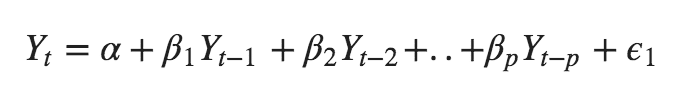(1)

where, $Y{t-1}$ is the lag 1 value of Y, $\beta1$ is the coefficient of lag 1 and $\alpha$ is the intercept term. 


MA model equation is one where Y(t) depends only on the lagged forecast errors and not the lagged variable values. Its equation is as follows:
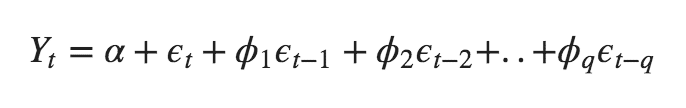 (1)
where, et-1, et-2 are the errors from the lagged forecasted values and phi are the coefficients estimated by model

ARIMA combines these two equations for the differences series.
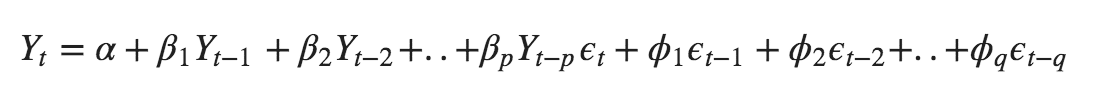 (1)

There is a need to find out correct order of differencing to avoid underfitting and overfitting. If the autocorrelations are positive for many number of lags (10 or more), then the series needs further differencing. On the other hand, if the lag 1 autocorrelation itself is too negative, then the series is probably over-differenced. 

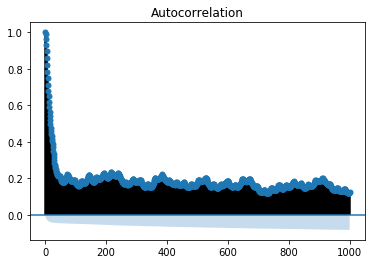

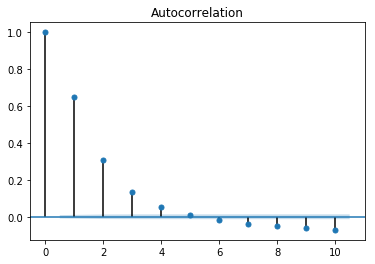

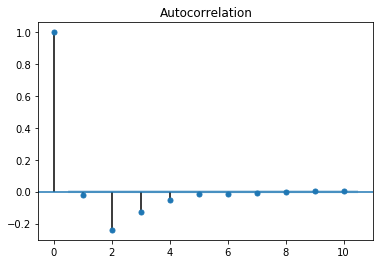

In [84]:
series3=series
# Original Series

plot_acf(series3,lags=1000)

# 1st Differencing

plot_acf(series3.diff().dropna(),lags=10)

# 2nd Differencing

plot_acf(series3.diff().diff().dropna(),lags=10)

plt.show()
plt.close()


It could be seen that the series is non-stationary as it had multiple lags when it is not differentiated.
when series is differenciated once, there is a sharp  and lag 1 was positive and on second differencing there is a negative corelation at lag 1. The behaviiour exbhited on second differencing happend when series is over differentiated. 
Tentatively, we will assume d =1.

Following are rules for identifying the order of differencing and the constant given in  https://people.duke.edu/~rnau/arimrule.htm, which I find really helpful.

" Rule 1: If the series has positive autocorrelations out to a high number of lags (say, 10 or more), then it probably needs a higher order of differencing.

Rule 2: If the lag-1 autocorrelation is zero or negative, or the autocorrelations are all small and patternless, then the series does not need a higher order of differencing. If the lag-1 autocorrelation is -0.5 or more negative, the series may be overdifferenced.  BEWARE OF OVERDIFFERENCING.

Rule 3: The optimal order of differencing is often the order of differencing at which the standard deviation is lowest. (Not always, though. Slightly too much or slightly too little differencing can also be corrected with AR or MA terms. See rules 6 and 7.)

Rule 4: A model with no orders of differencing assumes that the original series is stationary (among other things, mean-reverting). A model with one order of differencing assumes that the original series has a constant average trend (e.g. a random walk or SES-type model, with or without growth). A model with two orders of total differencing assumes that the original series has a time-varying trend (e.g. a random trend or LES-type model).

Rule 5: A model with no orders of differencing normally includes a constant term (which allows for a non-zero mean value). A model with two orders of total differencing normally does not include a constant term. In a model with one order of total differencing, a constant term should be included if the series has a non-zero average trend. "

Further ACF and PACF plots are used to determine p and q terms. 

Partial autocorrelation for determining AR term (p) conveys the pure correlation between a lag and the series, after excluding the contributions from the intermediate lags. (1) The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags. (2)
(#Page 81, Section 4.5.6 Partial Autocorrelations, Introductory Time Series with R)

Any autocorrelation in a stationarized series can be rectified by adding enough AR terms (indicated below in rule 6). So, we initially take the order of AR term to be equal to (2 or 3 in our case) as many lags that crosses the significance limit in the PACF plot.

An MA term is the number of the error of the lagged forecast terms in the model. The ACF plots tells how many 'q' terms are required to remove any autocorrelation in the stationarized series.

Let’s see the ACF and PACF plots of the differenced series.


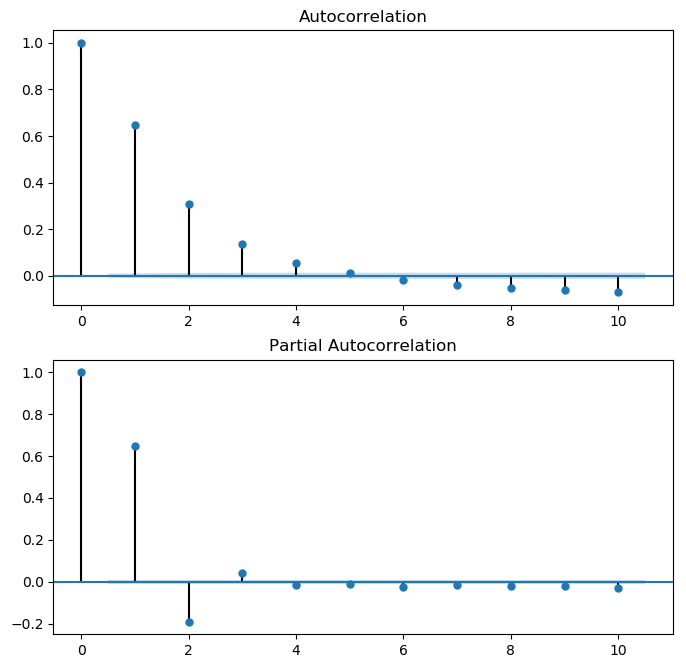

In [51]:
series2=series.diff().dropna()
fig, axes = plt.subplots(2,1,figsize=(8,8), dpi= 100)
# plot_acf(df.value.tolist(), lags=50, ax=axes[0])
# plot_pacf(df.value.tolist(), lags=50, ax=axes[1])
# plt.figure(figsize=(10,10), dpi=100)
plot_acf(series2,lags=10,ax=axes[0])
# plt.title('ACF')
# plt.show()
plot_pacf(series2,lags=10,ax=axes[1])
# plt.title('PACF')
plt.show()
plt.close()

In ACF plot, couple of lags are well above the significance line. So, let’s tentatively fix q as 4. Lets start with the simple model that sufficiently explains the Y. As we can observe that the PACF at lag 1 is quite significant asit is above the significance line. Let us tentatively fix the p as 1.

The same website  (https://people.duke.edu/~rnau/arimrule.html) also gives the rules for identifying the numbers of AR and MA terms for incorporating in the model for forecastng.

" Rule 6: If the partial autocorrelation function (PACF) of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is positive--i.e., if the series appears slightly "underdifferenced"--then consider adding one or more AR terms to the model. The lag beyond which the PACF cuts off is the indicated number of AR terms.

Rule 7: If the autocorrelation function (ACF) of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is negative--i.e., if the series appears slightly "overdifferenced"--then consider adding an MA term to the model. The lag beyond which the ACF cuts off is the indicated number of MA terms.

Rule 8: It is possible for an AR term and an MA term to cancel each other's effects, so if a mixed AR-MA model seems to fit the data, also try a model with one fewer AR term and one fewer MA term--particularly if the parameter estimates in the original model require more than 10 iterations to converge. BEWARE OF USING MULTIPLE AR TERMS AND MULTIPLE MA TERMS IN THE SAME MODEL.

Rule 9: If there is a unit root in the AR part of the model--i.e., if the sum of the AR coefficients is almost exactly 1--you should reduce the number of AR terms by one and increase the order of differencing by one.

Rule 10: If there is a unit root in the MA part of the model--i.e., if the sum of the MA coefficients is almost exactly 1--you should reduce the number of MA terms by one and reduce the order of differencing by one.

Rule 11: If the long-term forecasts* appear erratic or unstable, there may be a unit root in the AR or MA coefficients. "

Our p and q selection follows the 6 rule. Let's check for unit root in next step. We will verify rule 11 after we finish forecast step.

Developing model

Now that we have determined the values of p, d and q, we have everything needed to fit the ARIMA model. Let’s use the ARIMA() implementation in statsmodels package. Order of 1,1,4 and 1,1,3 had p values of MA terms above 0.05, so model was corrected by decreasing MA / q term to 2.

In [91]:
from statsmodels.tsa.arima_model import ARIMA
order=(1,1,2)#p,d,q
model = ARIMA(series, order=order)
model_fit = model.fit(disp=0)
print(model_fit.summary())


C:\Users\Bhavya\Anaconda1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Bhavya\Anaconda1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:          D.Wind Actual   No. Observations:                46703
Model:                 ARIMA(1, 1, 2)   Log Likelihood             -340379.779
Method:                       css-mle   S.D. of innovations            353.977
Date:                Tue, 15 Oct 2019   AIC                         680769.557
Time:                        14:53:05   BIC                         680813.315
Sample:                    01-01-2014   HQIC                        680783.308
                         - 04-30-2019                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0761      4.046      0.019      0.985      -7.854       8.006
ar.L1.D.Wind Actual     0.4508      0.012     36.128      0.000       0.426       0.475
ma.L1.D.Wind Act

The table in the middle is the coefficients table where the values under ‘coef’ are the coefficients of the respective MA and AR terms. Our AR and MA coeffiecients from model dont add up to 1 individually thus eliminating rule 9 and 10. 
The coefficient of the MA and Ar terms are close to zero and the P-Value in ‘P>|z|’ column is highly significant as they are less than 0.05.  AIC is large but can be compared to other models.  
Lets try with decreasing  MA and AR terms. 


In [93]:
order=(1,1,3)#p,d,q
model1 = ARIMA(series, order=order)
model_fit1 = model1.fit(disp=0)
print(model_fit1.summary())

C:\Users\Bhavya\Anaconda1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Bhavya\Anaconda1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:          D.Wind Actual   No. Observations:                46703
Model:                 ARIMA(1, 1, 3)   Log Likelihood             -340379.463
Method:                       css-mle   S.D. of innovations            353.975
Date:                Tue, 15 Oct 2019   AIC                         680770.925
Time:                        14:55:10   BIC                         680823.434
Sample:                    01-01-2014   HQIC                        680787.426
                         - 04-30-2019                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0761      4.033      0.019      0.985      -7.828       7.980
ar.L1.D.Wind Actual     0.4326      0.027     16.266      0.000       0.380       0.485
ma.L1.D.Wind Act

AIC is even higer and the P value for the MA 2 term is higher, so let us move on with model 1 now. 
Lets plot residualsLet’s plot the residuals to ensure there are no patterns (that is, look for constant mean and variance).

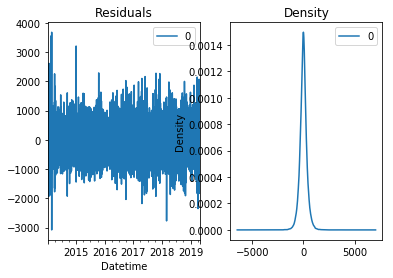

In [94]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

The residual errors seem fine with near zero mean and uniform variance. 
Let’s plot the actuals against the fitted values using plot_predict().

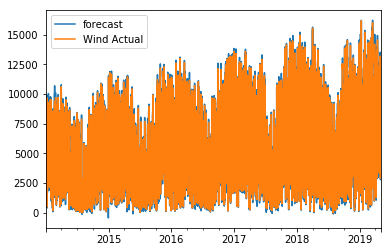

In [95]:
model_fit.plot_predict(dynamic=False)
plt.show()

The model seem good, but the real validation is done using the Out-of-Time cross-validation.

In Out-of-Time cross-validation series is forecasted on unseen data and then comparing the forecast against the actuals gives accuracy of model.

To do out-of-time cross-validation, we split the data to training and testing dataset in 7:3 ratio. Importantly, data is not randomly split, instead a sequence from the end is taken out for validation to keep the series intact.

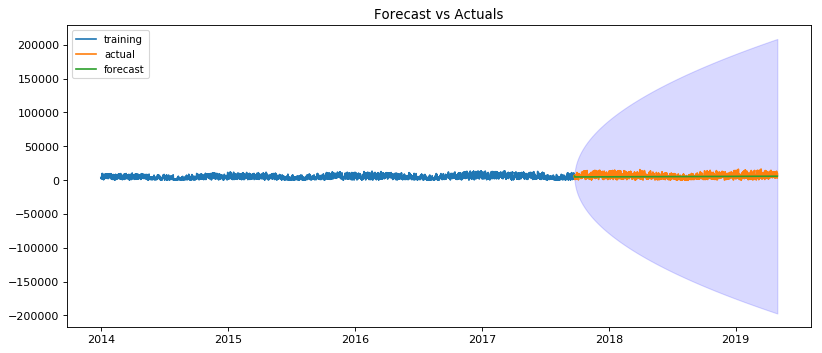

In [96]:
fc, se, conf = model_fit.forecast(len(test), alpha=0.05)  # 95% cI
# print(test.index)
fc_series = pd.Series(fc, index=test.index)
lbound = pd.Series(conf[:, 0], index=test.index)
ubound = pd.Series(conf[:, 1], index=test.index)
plt.figure(figsize=(12,5), dpi=80)
plt.fill_between(lbound.index, lbound, ubound,color='b', alpha=.15)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=9)
plt.show()

From the chart, the ARIMA(1,1,2) model seems to give a forecast in direct direction. And the actual observed values lie within the 95% confidence band. That seems fine and each of the predicted forecasts is consistent with actuals. On higher MA and AR terms, the observed values are outside the 95% CI. 

Metrics to measure the accuracy of the model

a.Mean Absolute Percentage Error (MAPE)

b.Mean Error (ME)

c.Mean Absolute Error (MAE)

d.Mean Percentage Error (MPE)

e.Root Mean Squared Error (RMSE)

f.Lag 1 Autocorrelation of Error (ACF1)

g.Correlation between the Actual and the Forecast (corr)

h.Min-Max Error (minmax)

a, g, h are used for comparing series, but in our case we use only b,c,d,e


In [97]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = (np.mean((forecast - actual)**2)**.5 ) # RMSE
    acf1 = acf(fc-test)[1]                      # ACF1
    print('mean error:',me, 'MAE:', mae, 'rmse:',rmse, 'acf1:',acf1)

forecast_accuracy(fc, test.values) #(https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/)

mean error: -987.8257957687143 MAE: 2991.609289658155 rmse: 3713.342521944875 acf1: 0.9890748710985041


The RMSE is higher when higher AR and MA terms are used. To compare our assumptions with other combinationa, pmdarima library is used. It builds the model on various p, q combinations. 

In [8]:
model = pm.auto_arima(series, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=None, max_q=None, # maximum p and q to test              
                      d=1,             
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True)

print(model.summary())

TypeError: '<' not supported between instances of 'NoneType' and 'int'

Our Model ARIMA (1,1,2) is good , as it has nearly same AIC and BIC, so our initial guesses were right.  

As discussed earlier, the stationarized regression model are one that uses lags of the dependent variables or lags of the forecast errors as regressors. Regression is linear regression could be modeled using linear regression algorithm or using ar model or ma model individually. 

Using linear regression, a forecast problem could be solved with following steps:
1. Data is read from CSV file (In this tutorial, we use data also exported)
2. Data is scaled (scale())
3. Data is converted in to a supervised learning data set (series_to_supervised())
4. Data is split into train and test sets (preparedata() )
5. Model is developed on train
6. Model is used to predict on test data
7. Model forecasts new data (forecastnew() )

This model predicts a time step ahead only based on the lags of its own series and doesnot count for the error of the previous forecasts.
As in ARIMA, the number of p term (AR)term can be adjusted here which is n_lag (no. of lags) variable in this model. The series is not differentiated for convinience mostly to avoid problem of integrating. 

In [31]:
def series_to_supervised(series, n_lag=1, n_seq=1, dropnan=True):
    # always input list
    newDF = pd.DataFrame(series)
    values, names = list(), list()
    for i in range(n_lag, 0, -1):
        values.append(newDF.shift(i))
        names += [('y(t-%i)' % ( i))]
    for i in range(0, n_seq):
        values.append(newDF.shift(-i))
        names += [('y(t+%i)' % (i))]
    agg = pd.concat(values, axis=1)
    agg.columns = names
    agg=agg.dropna()
    return agg
# (series_to_supervised(series,2,2))
# referred https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

In [32]:
ntest=1000
n_lag=2 #Number of lag observations as input (X).
n_seq=1 #Number of observations as output (y).

In [35]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return (diff)

def scale(series11):
    series11 = np.array(series11).reshape(len(series11), 1)
    scaler = MinMaxScaler()
    scalevalue = scaler.fit_transform(series11)
    scalevalue = scalevalue.reshape(len(scalevalue), 1)
    return scalevalue,scaler

def preparedata(X,n_lag, n_seq,ntest):
    diffvalues=X
#     for i in range(1):
#         diffvalues = difference(diffvalues, 1)
    scaledvalues,scaler=scale(diffvalues)
    supervisedvalues= series_to_supervised(scaledvalues, n_lag, n_seq)
    train, test = supervisedvalues[0:-ntest], supervisedvalues[-ntest:]
    train=np.array(train)
    # print(train)
    test=np.array(test)
    trainX=train[:,0:n_lag]
    trainY=train[:,n_lag:n_lag+n_seq]
    testX=test[:,0:n_lag]
    testY=test[:,n_lag:n_lag+n_seq]
    return trainX,trainY,testX,testY,scaler
trainX,trainY,testX,testY,scaler=preparedata(X,n_lag, n_seq,ntest)

C:\Users\Bhavya\Anaconda1\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [39]:
def forecastnew(ntimes,X,ntest,prediction):
    trainX,trainY,testX,testY,scaler=preparedata(X,n_lag, n_seq,ntest)
#     reg = LinearRegression()
#     reg.fit(trainX, trainY)
#     prediction=reg.predict(testX)
    predicted=[]
    Prediction=0
    for i in range(ntimes):
        ntest=1
        X=np.append(X,prediction[-1])
        trainX,trainY,testX,testY,scaler1=preparedata(X,n_lag, n_seq,ntest)
        prediction=reg.predict(testX)
        Prediction = scaler1.inverse_transform(prediction)
        X[-1]=Prediction[0][0]
        predicted.append(Prediction[0][0])
    return predicted
# predicted=forecastnew(100,X,ntest,predictiontest)
# plt.plot(predicted)

b1:  [[-0.6572719788261193, 1.638823026713565]]
b0:  [0.00603862]


C:\Users\Bhavya\Anaconda1\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


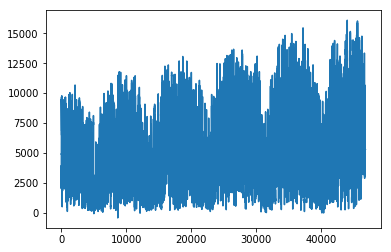

Accuracy on train data: 98.74227563211949
Accuracy on test data: 97.16000934366062


In [41]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(trainX, trainY)
b1 = reg.coef_
b0 = reg.intercept_
print("b1: ",b1.tolist())
print("b0: ",b0)
predictiontest=scaler.inverse_transform(reg.predict(testX))
predictiontrain=scaler.inverse_transform(reg.predict(trainX))
predicted=forecastnew(100,X,ntest,predictiontest)
mergedtrain = list(itertools.chain.from_iterable(predictiontrain))
mergedtest = list(itertools.chain.from_iterable(predictiontest))
fcvalues=mergedtrain+mergedtest+predicted
plt.plot(fcvalues)
plt.show()
plt.close()
print("Accuracy on train data:",reg.score(trainX,trainY)*100)
print("Accuracy on test data:",reg.score(testX,testY)*100)

As observed, this model predicts the train data with 98% accuracy and unseen test data 96%, but doesnot perform good on forecasting as the predictions carry errors from previous time steps which this model doesnot account for.

As discussed earlier, the stationarized regression model can be developed with inbuilt ar model or ma model individually. 
The series are differenced once and AR model is developed and predicted on 30 % of data as validation data. It can be seen that as AR term increases, RMSE on test data increases as the model overfits. 

C:\Users\Bhavya\Anaconda1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


RMSE for AR1 model is 186.89979955111406


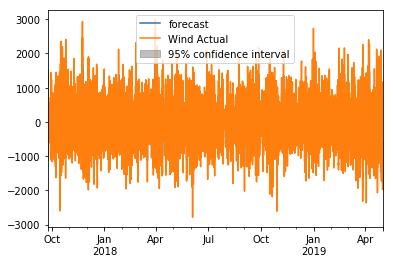

C:\Users\Bhavya\Anaconda1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


RMSE for AR2 model is 203.93458754476953


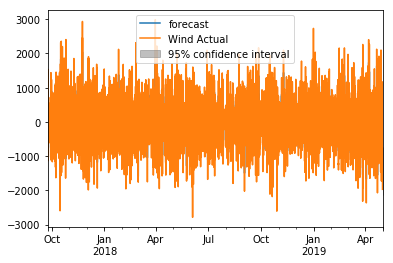

C:\Users\Bhavya\Anaconda1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


RMSE for AR3 model is 203.9666602684051


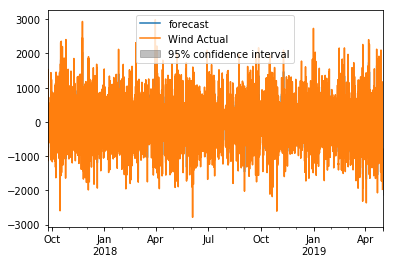

In [42]:
from statsmodels.tsa.arima_model import ARMA
series3=series
# differncing the series once
for i in range(1):
    series2=series3.diff().dropna()
lenx=len(series2)
nlong=int(0.7*len(series1))

# AR (n) model
for k in range(3): 
    series1=series2
    mod = ARMA(series1, order=(k+1,0))
    res = mod.fit()
    res.plot_predict(start=nlong, end=lenx)
    x=res.predict(start=nlong, end=lenx)
    i=len(x)-len(series1[nlong:lenx])
    rmse=math.sqrt(mse(series1[nlong:lenx],x[i:]))
    print('RMSE for AR%i model is'%(k+1),rmse )
    plt.show()
    plt.close()

Similarly, MA model is developed and predicted on 30 % of data as validation data. It can be seen that as MA models have less RMSE also that as MA term increases, RMSE on test data decreases as the model fits well at q of 2. 

C:\Users\Bhavya\Anaconda1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


RMSE for MA1 model is 326.96014252163263


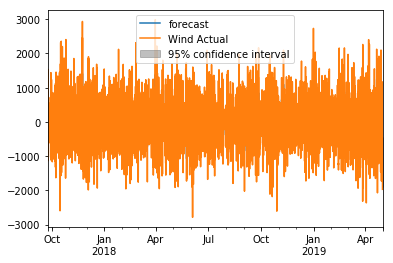

C:\Users\Bhavya\Anaconda1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


RMSE for MA2 model is 251.34781974105292


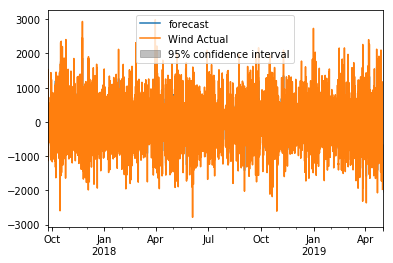

In [43]:
from statsmodels.tsa.arima_model import ARMA
series3=series
# differncing the series once
for i in range(1):
    series2=series3.diff().dropna()
lenx=len(series2)
nlong=int(0.7*len(series1))

# MA (n) model
for k in range(2): 
    series1=series2
    mod = ARMA(series1, order=(0,k+1))
    res = mod.fit()
    res.plot_predict(start=nlong, end=lenx)
    x=res.predict(start=nlong, end=lenx)
    i=len(x)-len(series1[nlong:lenx])
    rmse=math.sqrt(mse(series1[nlong:lenx],x[i:]))
    print('RMSE for MA%i model is'%(k+1),rmse )
    plt.show()
    plt.close()

#arma ar1 error= 143.65, ma1 251 ma2 199.3 
#ar2 = 158, (2,1) = 157.2 same a little inc for 3,1, 1,1 156.2

In [ ]:
# References:
#     1.https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
#     2.https://www.machinelearningplus.com/time-series/time-series-analysis-python/
#     3.https://towardsdatascience.com/unboxing-arima-models-1dc09d2746f8
#     4. https://people.duke.edu/~rnau/arimrule.htm
#     5. https://pythondata.com/forecasting-time-series-autoregression/